Notebook to analyse the relation of the amount of SBP adoption in each municipality in each year with the various features, only for the municipalities and years in which there was adoption.

2nd step of the double hurdle model.

## Content
* Data ingestion
* Data first exploration
* Features analysis
    * Variance analysis
    * Correlation - Spearman rho and correlation matrices
        * All years
        * Restricted to PCF years (and comparison with all years)
        * Low correlations
        * Squared cumulative adoption
        * Census features combinations
* Multicollinearity analysis (VIF)
    * With census features combined and not
* Outliers removal

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
# For plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
path_to_final_dataset = "Municipalities final dataset for analysis.csv"

In [4]:
# How to display floats
pd.options.display.float_format = '{:.3f}'.format
np.set_printoptions(precision=6)

# Data ingestion

In [5]:
dataset_original = pd.read_csv(path_to_final_dataset, index_col=['Municipality', 'Year'])

### Restrict to the municipalities and years with non-null adoption 

In [6]:
mask_no_adoption = dataset_original['adoption_in_year'] < 0.0000001
dataset_original = dataset_original.drop(dataset_original.loc[mask_no_adoption].index)
len(dataset_original)

2466

In [7]:
dataset = dataset_original.reset_index(drop=True)

In [8]:
dataset.head(2)

,adoption_in_year,tot_cumul_adoption_pr_y_munic,tot_cumul_adoption_pr_y_port,pastures_area_var,pastures_area_munic,pastures_area_mean,agric_area_mean,agric_area_owned,tract_100ha,lu_cattle,...,days_min_t_under_0_average_munic,av_prec_sum_average_munic,days_no_prec_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic,pH_mean_munic,sbp_payment
0,0.001,0.000,0.001,0.426,0.264,0.569,2.220,0.613,13.600,0.710,...,13.306,1029.408,271.403,49.111,10.764,17.127,2.340,17.505,5.274,0.000
1,0.001,0.001,0.002,0.455,0.285,0.635,2.280,0.617,14.100,0.710,...,13.306,1029.408,271.403,49.111,10.764,17.127,2.340,17.505,5.274,0.000


In [9]:
dataset.columns

Index(['adoption_in_year', 'tot_cumul_adoption_pr_y_munic',
       'tot_cumul_adoption_pr_y_port', 'pastures_area_var',
       'pastures_area_munic', 'pastures_area_mean', 'agric_area_mean',
       'agric_area_owned', 'tract_100ha', 'lu_cattle', 'lu_per_agric_area',
       'farmers_female', 'farmers_over65', 'educ_none', 'educ_second_super',
       'agric_time_full', 'inc_excl_agric', 'inc_mainly_ext',
       'work_unit_100ha', 'av_d_mean_t_pr_y_munic',
       'days_mean_t_over_20_pr_y_munic', 'days_mean_t_over_25_pr_y_munic',
       'av_d_max_t_pr_y_munic', 'days_max_t_over_30_pr_y_munic',
       'av_d_min_t_pr_y_munic', 'days_min_t_under_0_pr_y_munic',
       'av_prec_sum_pr_y_munic', 'days_no_prec_pr_y_munic',
       'cons_days_no_prec_pr_y_munic', 'av_d_mean_t_average_munic',
       'days_mean_t_over_20_average_munic',
       'days_mean_t_over_25_average_munic', 'av_d_max_t_average_munic',
       'days_max_t_over_30_average_munic', 'av_d_min_t_average_munic',
       'days_min_t_und

## Organise features by categorical/numerical and by topic

In [10]:
label = ['adoption_in_year']

In [11]:
features_list = [col for col in dataset.columns if col != 'adoption_in_year']
features = pd.DataFrame(index=dataset.columns, columns=['num/cat', 'topic'])

In [12]:
adoption_features = [feat for feat in features.index if 'adoption' in feat and feat not in label]
features.loc[adoption_features, :] = ['num', 'SBP_adoption']

In [13]:
climate_features = [feat for feat in features.index if '_t_' in feat or '_prec_' in feat]
features.loc[climate_features, :] = ['num', 'climate']

In [14]:
soil_features = ['CaCO3_mean_munic', 'CN_mean_munic', 'N_mean_munic', 'P_mean_munic', 'pH_mean_munic']
features.loc[soil_features, :] = ['num', 'soil']

In [15]:
economic_features = ['sbp_payment']
features.loc[economic_features, :] = ['num', 'economic']

In [16]:
features_not_census = adoption_features + climate_features + soil_features + economic_features 
census_features = [feat for feat in features_list if feat not in features_not_census]
features.loc[census_features, :] = ['num', 'census']

# First exploration

In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 45 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   adoption_in_year                   2466 non-null   float64
 1   tot_cumul_adoption_pr_y_munic      2466 non-null   float64
 2   tot_cumul_adoption_pr_y_port       2466 non-null   float64
 3   pastures_area_var                  2466 non-null   float64
 4   pastures_area_munic                2466 non-null   float64
 5   pastures_area_mean                 2466 non-null   float64
 6   agric_area_mean                    2466 non-null   float64
 7   agric_area_owned                   2466 non-null   float64
 8   tract_100ha                        2466 non-null   float64
 9   lu_cattle                          2466 non-null   float64
 10  lu_per_agric_area                  2466 non-null   float64
 11  farmers_female                     2466 non-null   float

In [18]:
dataset.describe()

,adoption_in_year,tot_cumul_adoption_pr_y_munic,tot_cumul_adoption_pr_y_port,pastures_area_var,pastures_area_munic,pastures_area_mean,agric_area_mean,agric_area_owned,tract_100ha,lu_cattle,...,days_min_t_under_0_average_munic,av_prec_sum_average_munic,days_no_prec_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic,pH_mean_munic,sbp_payment
count,2466.000,2466.000,2466.000,2466.000,2466.000,2466.000,2466.000,2466.000,2466.000,2466.000,...,2466.000,2466.000,2466.000,2466.000,2466.000,2466.000,2466.000,2466.000,2466.000,2466.000
mean,0.005,0.023,0.022,1.057,0.297,11.064,23.258,0.764,11.148,0.396,...,7.355,782.206,283.550,63.095,24.949,14.032,1.684,16.463,5.809,12.045
std,0.013,0.055,0.019,1.358,0.252,19.562,34.041,0.133,10.776,0.247,...,8.731,248.350,15.365,13.907,29.320,2.349,0.435,6.593,0.537,39.080
min,0.000,0.000,0.000,0.009,0.001,0.001,1.100,0.359,0.300,0.011,...,0.000,482.106,235.396,29.521,1.185,10.109,0.565,5.924,4.923,0.000
25%,0.001,0.002,0.007,0.706,0.073,0.193,2.680,0.679,1.620,0.164,...,0.440,583.446,276.442,53.417,6.457,11.823,1.408,11.004,5.306,0.000
50%,0.002,0.008,0.017,0.938,0.222,1.271,5.700,0.769,7.410,0.401,...,4.056,723.989,284.417,61.596,14.573,13.901,1.592,16.094,5.766,0.000
75%,0.005,0.023,0.035,1.053,0.493,13.686,37.073,0.873,18.720,0.598,...,11.031,896.837,295.581,74.583,32.340,16.230,2.050,21.138,6.156,0.000
max,0.357,0.874,0.070,32.708,0.937,135.392,173.500,0.996,64.760,1.000,...,38.417,1573.570,307.500,89.742,174.955,19.020,3.046,35.973,7.267,153.260


array([[<AxesSubplot:title={'center':'adoption_in_year'}>]], dtype=object)

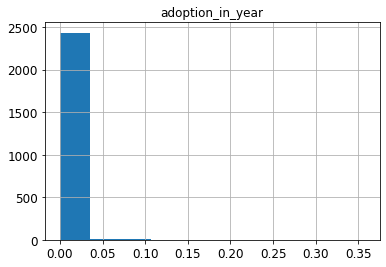

In [19]:
# Target variable distribution
dataset[label].hist()

In [20]:
adoption_features = features.loc[features['topic'] == 'SBP_adoption'].index.tolist()
#dataset[adoption_features].hist(figsize=(20, 20))

In [21]:
census_features = features.loc[(features['topic'] == 'census')].index.tolist()
#dataset[census_features].hist(figsize=(20, 20))

In [22]:
climate_features = features.loc[features['topic'] == 'climate'].index.tolist()
#dataset[climate_features].hist(figsize=(20, 20))

In [23]:
soil_features = features.loc[features['topic'] == 'soil'].index.tolist()
#dataset[soil_features].hist(figsize=(15, 8))

In [24]:
features_num = features.loc[features['num/cat'] == 'num'].index.tolist()

# Features analysis

## Correlation analysis with label - Spearman rho and matrices

#### Test for normality distribution the datasets' columns

In [25]:
from scipy.stats import kstest

results_ks = pd.DataFrame(index=features_num, columns=['statistic', 'p-value'])
for (columnName, columnData) in dataset.iteritems():
    stat, p = kstest(columnData, 'norm')
    results_ks.loc[columnName] = [stat, p]

In [26]:
(results_ks['p-value'] > 0.05).any()

False

### All years

In [27]:
from scipy.stats import spearmanr

def get_spearmanr_results(features):
    results = pd.DataFrame(index=features, columns=['spearman r'])

    for (columnName, columnData) in dataset[features].iteritems():
        coef, p = spearmanr(columnData, dataset['adoption_in_year'])
        results.loc[columnName] = coef
    return results

In [28]:
spearman_results = get_spearmanr_results(features_num)

In [29]:
spearman_results.loc[adoption_features, :].sort_values('spearman r', ascending=False)

,spearman r
tot_cumul_adoption_pr_y_munic,0.685
tot_cumul_adoption_pr_y_port,0.441


In [30]:
spearman_results.loc[census_features, :].sort_values('spearman r', ascending=False)

,spearman r
pastures_area_var,0.353
educ_second_super,0.246
farmers_over65,0.162
pastures_area_mean,0.162
agric_area_mean,0.136
pastures_area_munic,0.126
inc_excl_agric,0.068
lu_cattle,-0.005
farmers_female,-0.008
lu_per_agric_area,-0.014


In [31]:
spearman_results.loc[climate_features, :].sort_values('spearman r', ascending=False)

,spearman r
av_d_max_t_pr_y_munic,0.328
days_max_t_over_30_pr_y_munic,0.328
days_mean_t_over_25_pr_y_munic,0.235
days_mean_t_over_20_pr_y_munic,0.207
days_mean_t_over_25_average_munic,0.176
days_max_t_over_30_average_munic,0.168
av_d_max_t_average_munic,0.168
days_no_prec_pr_y_munic,0.128
days_mean_t_over_20_average_munic,0.126
av_d_min_t_average_munic,0.093


In [32]:
spearman_results.loc[soil_features, :].sort_values('spearman r', ascending=False)

,spearman r
pH_mean_munic,0.137
CaCO3_mean_munic,0.084
P_mean_munic,-0.083
CN_mean_munic,-0.091
N_mean_munic,-0.284


In [33]:
economic_features = features.loc[(features['topic'] == 'economic')].index.tolist()
spearman_results.loc[economic_features, :].sort_values('spearman r', ascending=False)

,spearman r
sbp_payment,0.280


#### Corrrelation matrix to spot also relation among the features

In [34]:
corr_matrix_sp = dataset.corr(method='spearman').round(decimals=2)

In [35]:
def plot_correlation_heatmap(matrix, size=(20, 20)):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(matrix)
    im.set_clim(-1, 1)
    ax.grid(False)
    ax.xaxis.set(ticks=range(len(matrix.index)), ticklabels=matrix.index)
    plt.xticks(rotation=90)
    ax.yaxis.set(ticks=range(len(matrix.columns)), ticklabels=matrix.columns)
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            ax.text(j, i, matrix.iloc[i, j], ha='center', va='center',
                    color='r')
    cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
    plt.show()

In [36]:
climate_features_average = [feat for feat in climate_features if 'average' in feat]

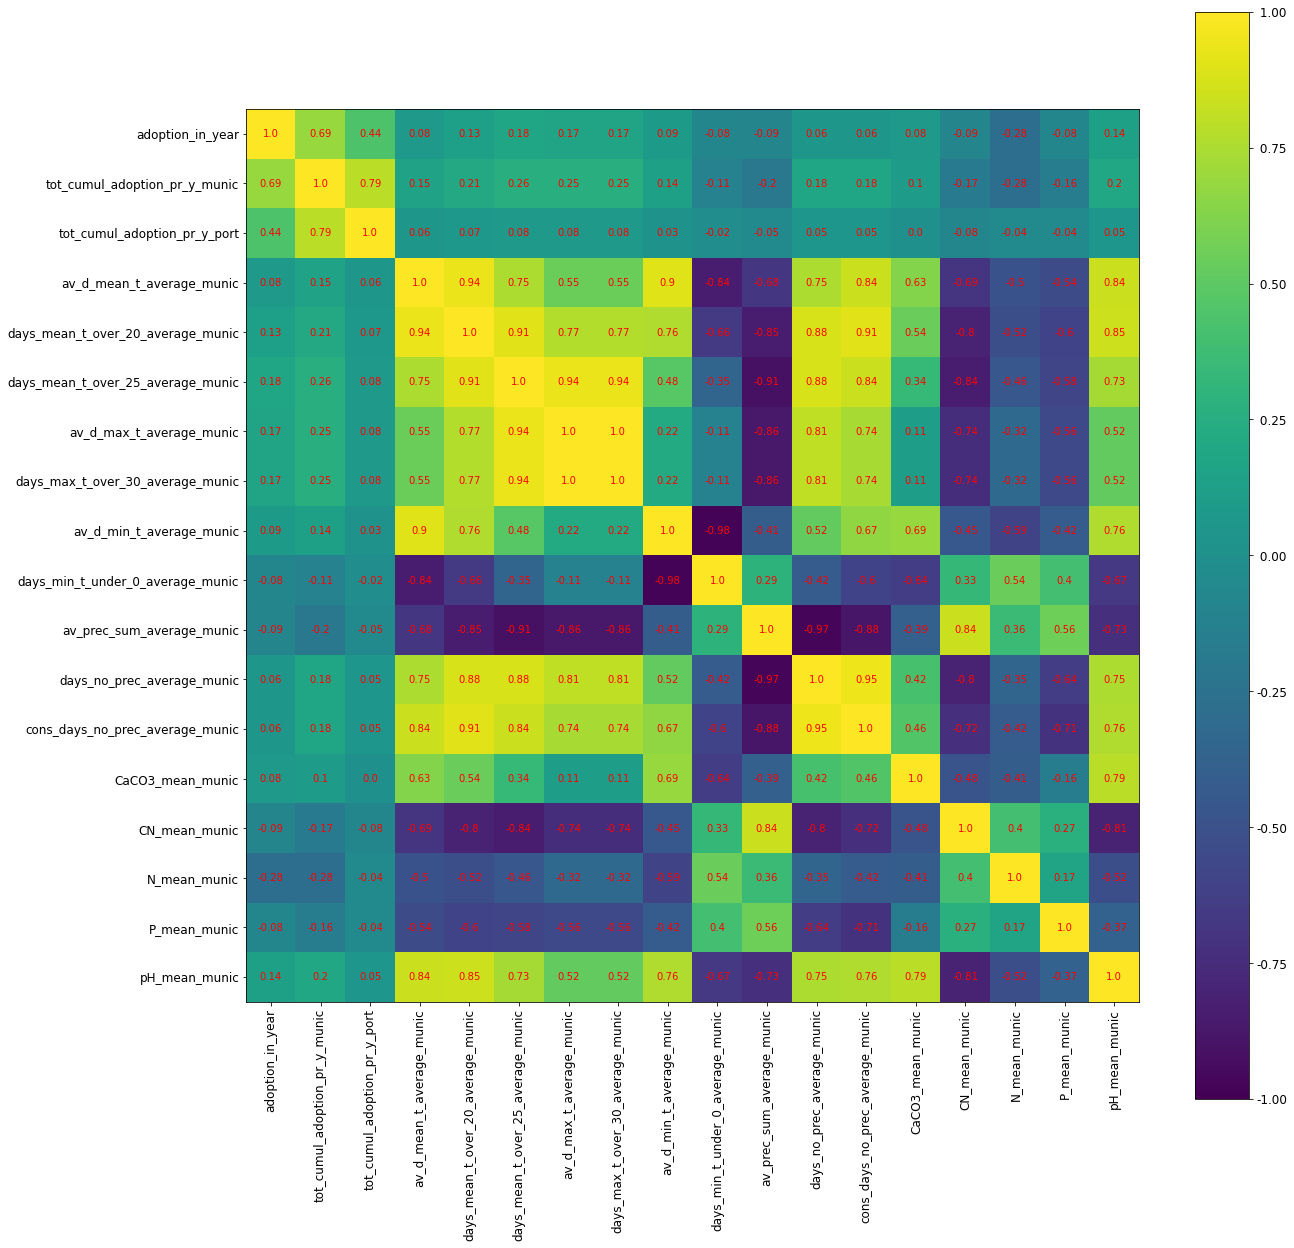

In [37]:
features_to_show = label + adoption_features + climate_features_average + soil_features
plot_correlation_heatmap(corr_matrix_sp.loc[features_to_show, features_to_show])

Correlation on census features

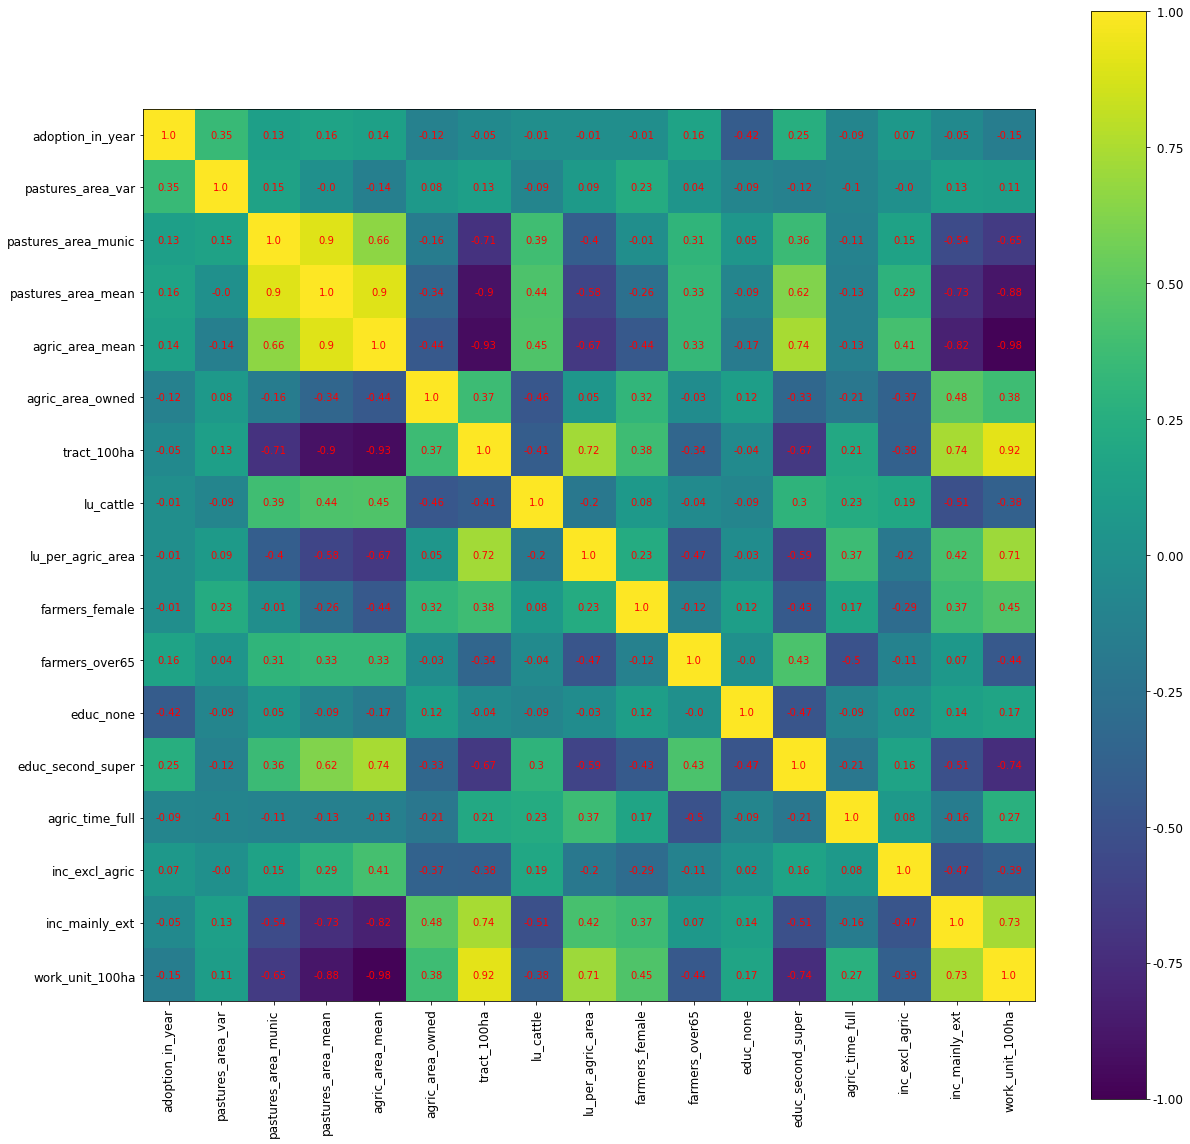

In [38]:
features_to_show = label + census_features
plot_correlation_heatmap(corr_matrix_sp.loc[features_to_show, features_to_show], size=(20, 20))

Environmental features

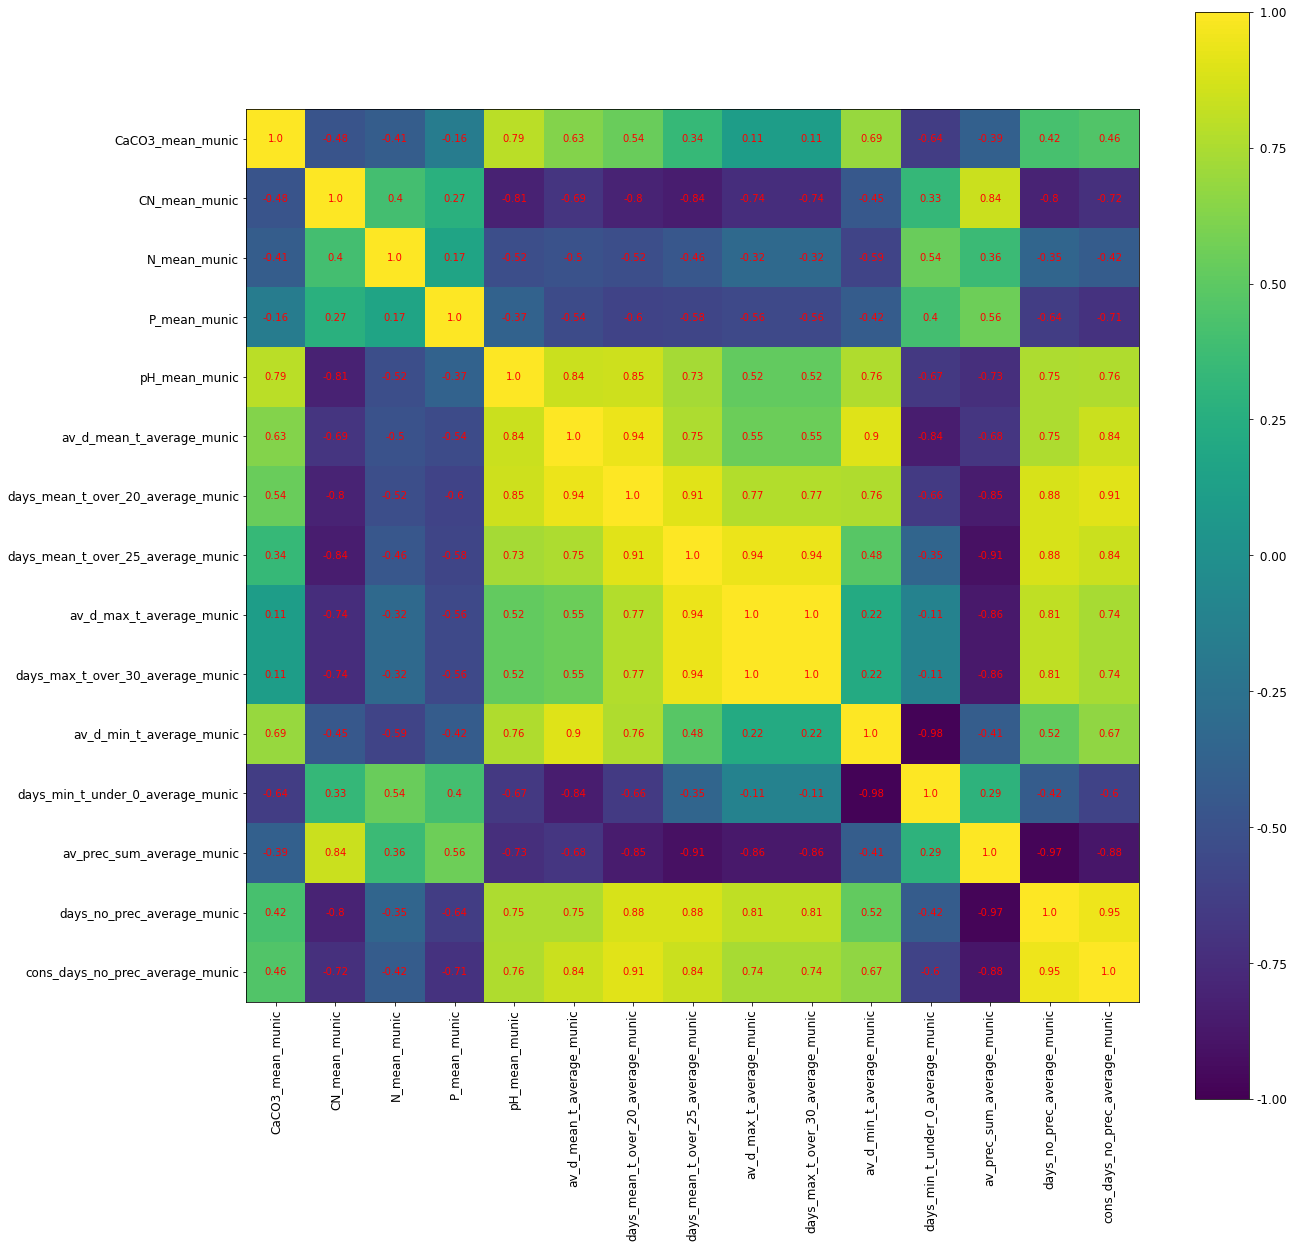

In [39]:
features_to_show = soil_features + climate_features_average
plot_correlation_heatmap(corr_matrix_sp.loc[features_to_show, features_to_show], size=(20, 20))

### Restricted to PCF years (and comparison with all years)¶

Analysis to check correlations only during the years of the PCF projects, since these are the years for which we have reliable labels.

In [40]:
dataset_PCF = dataset_original.loc[(slice(None), [2009, 2010, 2011, 2012]), :]

In [41]:
dataset_PCF = dataset_PCF.reset_index(drop=True)

In [42]:
len(dataset_PCF)

215

In [43]:
dataset_PCF.describe()

,adoption_in_year,tot_cumul_adoption_pr_y_munic,tot_cumul_adoption_pr_y_port,pastures_area_var,pastures_area_munic,pastures_area_mean,agric_area_mean,agric_area_owned,tract_100ha,lu_cattle,...,days_min_t_under_0_average_munic,av_prec_sum_average_munic,days_no_prec_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic,pH_mean_munic,sbp_payment
count,215.000,215.000,215.000,215.000,215.000,215.000,215.000,215.000,215.000,215.000,...,215.000,215.000,215.000,215.000,215.000,215.000,215.000,215.000,215.000,215.000
mean,0.013,0.074,0.060,1.012,0.580,36.911,58.654,0.691,2.480,0.583,...,5.253,604.885,293.736,72.108,21.413,12.043,1.495,13.322,6.081,138.156
std,0.023,0.079,0.008,0.045,0.201,30.305,40.784,0.109,2.649,0.203,...,7.240,66.741,4.814,6.784,17.245,1.229,0.217,5.038,0.326,9.367
min,0.000,0.000,0.048,0.900,0.068,0.491,5.700,0.411,0.300,0.058,...,0.023,482.106,281.215,54.842,2.612,10.109,1.004,6.606,5.321,128.790
25%,0.003,0.030,0.052,0.995,0.448,12.824,24.735,0.617,0.900,0.483,...,0.346,557.486,291.278,68.951,8.455,11.091,1.388,9.935,5.884,132.100
50%,0.008,0.044,0.056,1.000,0.618,27.313,52.800,0.689,1.480,0.621,...,2.972,598.781,295.292,73.125,17.763,11.820,1.495,12.219,6.067,137.960
75%,0.015,0.074,0.070,1.032,0.725,51.644,81.360,0.760,2.215,0.739,...,7.056,632.401,296.798,77.079,30.167,12.826,1.635,15.008,6.220,145.610
max,0.197,0.526,0.070,1.158,0.911,135.392,157.030,0.953,16.880,0.958,...,33.767,796.201,301.375,83.458,111.861,15.566,2.188,29.620,7.009,153.260


In [44]:
from scipy.stats import spearmanr

spearman_results_PCF = pd.DataFrame(index=features_num, columns=['spearman r only PCF'])

for (columnName, columnData) in dataset_PCF[features_num].iteritems():
    coef, p = spearmanr(columnData, dataset_PCF['adoption_in_year'])
    spearman_results_PCF.loc[columnName] = coef

In [46]:
# Merge with spearman rho results with all to compare
spearman_results_both = pd.concat([spearman_results_PCF, spearman_results], axis=1)

In [47]:
spearman_results_both.loc[adoption_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
tot_cumul_adoption_pr_y_munic,0.260,0.685
tot_cumul_adoption_pr_y_port,-0.011,0.441


In [48]:
spearman_results_both.loc[census_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
educ_second_super,0.356,0.246
lu_cattle,0.058,-0.005
work_unit_100ha,0.057,-0.153
agric_area_mean,0.055,0.136
agric_time_full,0.044,-0.086
tract_100ha,0.029,-0.048
agric_area_owned,0.001,-0.121
lu_per_agric_area,-0.005,-0.014
pastures_area_mean,-0.026,0.162
pastures_area_var,-0.039,0.353


In [49]:
spearman_results_both.loc[climate_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
days_mean_t_over_25_pr_y_munic,0.144,0.235
av_d_max_t_pr_y_munic,0.133,0.328
days_max_t_over_30_pr_y_munic,0.133,0.328
av_d_max_t_average_munic,0.130,0.168
days_max_t_over_30_average_munic,0.130,0.168
days_mean_t_over_25_average_munic,0.127,0.176
av_d_min_t_pr_y_munic,0.121,0.030
av_prec_sum_pr_y_munic,0.102,-0.164
av_d_mean_t_pr_y_munic,0.084,0.071
av_d_min_t_average_munic,0.075,0.093


In [50]:
spearman_results_both.loc[soil_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
pH_mean_munic,0.336,0.137
P_mean_munic,0.210,-0.083
CaCO3_mean_munic,0.175,0.084
CN_mean_munic,-0.108,-0.091
N_mean_munic,-0.229,-0.284


In [51]:
spearman_results_both.loc[economic_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
sbp_payment,-0.030,0.280


### Squared cumulative adoption

Addition of a feature reporting the square of the cumulative adoption, to test a second degree relation with this feature

In [52]:
def get_spearman_both(features, d, d_PCF):
    if features=='all':
        features = d.columns
    results = pd.DataFrame(index=features, columns=['spearman r only PCF', 'spearman r'])
    
    for (columnName, columnData) in d[features].iteritems():
        coef, _ = spearmanr(columnData, d['adoption_in_year'])
        results.loc[columnName, 'spearman r'] = coef
        
    for (columnName, columnData) in d_PCF[features].iteritems():
        coef, _ = spearmanr(columnData, d_PCF['adoption_in_year'])
        results.loc[columnName, 'spearman r only PCF'] = coef

    return results

In [127]:
features = ['cumul_squared']
sp_res = get_spearman_both(features, d, d_PCF)
sp_res.sort_values('spearman r', ascending=False)

NameError: name 'd_PCF' is not defined

KeyError: 'cumul_squared'

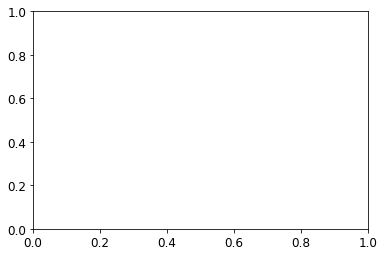

In [128]:
d.plot(kind='scatter', x='cumul_squared', y='adoption_in_year')

# Multicollinearity analysis (VIF)

**NOTE:** 
* dataset refers to the dataset with all features
* dataset_attr_red refers to the dataset with attributes reduced based on correlation coefficients

Based on dataset including all years (unless not clear)

In [54]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [55]:
def calculate_vif(dataset):
    features = "+".join([feat for feat in dataset.columns if feat != "adoption_in_year"])
    y, X = dmatrices('adoption_in_year ~' + features, dataset, return_type='dataframe')
    with pd.option_context('mode.use_inf_as_null', True):
        X = X.dropna()

    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif.set_index("features", inplace=True)
    return vif

In [56]:
vif = calculate_vif(dataset)

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [57]:
vif.sort_values('VIF', ascending=False).head(10)

,VIF
features,
av_d_max_t_pr_y_munic,inf
days_max_t_over_30_pr_y_munic,inf
days_max_t_over_30_average_munic,inf
av_d_max_t_average_munic,inf
Intercept,144670.863
days_mean_t_over_20_average_munic,498.061
av_d_mean_t_average_munic,478.902
av_d_min_t_average_munic,280.850
days_no_prec_average_munic,245.035


## Custom transformers to reduce features and multicollinearity

Create a different transformer for each topic of features, to not have any VIF above 10

In [58]:
from sklearn.base import BaseEstimator, TransformerMixin

In [59]:
def get_spearman_both(features, d, d_PCF):
    if features=='all':
        features = d.columns
    results = pd.DataFrame(index=features, columns=['spearman r only PCF', 'spearman r'])
    
    for (columnName, columnData) in d[features].iteritems():
        coef, _ = spearmanr(columnData, d['adoption_in_year'])
        results.loc[columnName, 'spearman r'] = coef
        
    for (columnName, columnData) in d_PCF[features].iteritems():
        coef, _ = spearmanr(columnData, d_PCF['adoption_in_year'])
        results.loc[columnName, 'spearman r only PCF'] = coef

    return results

In [60]:
corr_matrix = dataset.corr(method='spearman').round(decimals=2)

In [61]:
sp_r_both = get_spearman_both('all', dataset, dataset_PCF)

### Census features

In [62]:
census_features_indic = pd.concat(
    [spearman_results_both.loc[census_features, :], vif.loc[census_features]], axis=1, join='inner'
)

In [63]:
census_features_indic.sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r,VIF
pastures_area_var,-0.039,0.353,1.210
educ_second_super,0.356,0.246,5.932
farmers_over65,-0.183,0.162,4.256
pastures_area_mean,-0.026,0.162,10.620
agric_area_mean,0.055,0.136,12.330
pastures_area_munic,-0.223,0.126,6.658
inc_excl_agric,-0.230,0.068,2.381
lu_cattle,0.058,-0.005,3.468
farmers_female,-0.189,-0.008,3.500
lu_per_agric_area,-0.005,-0.014,2.538


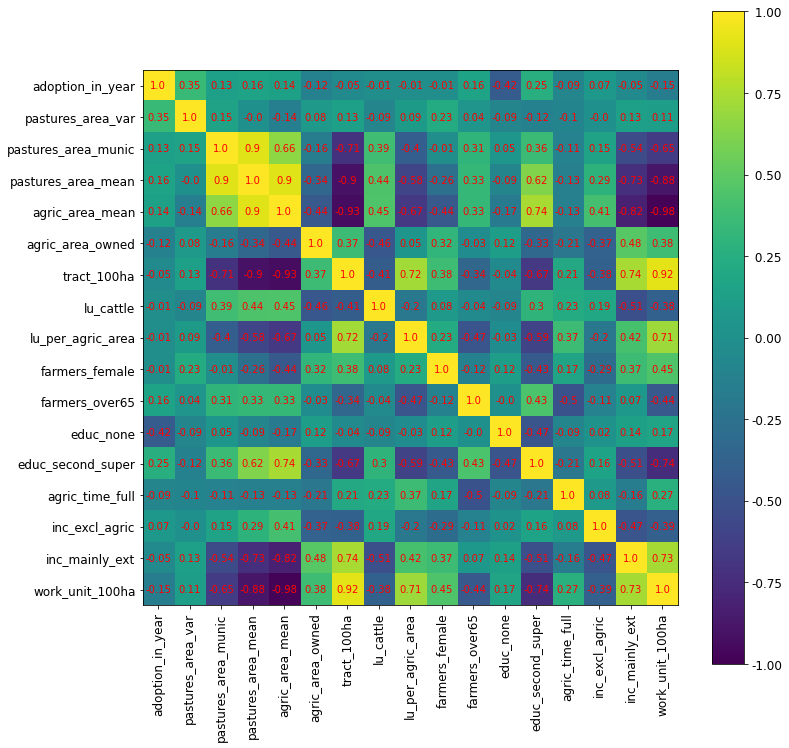

In [64]:
plot_correlation_heatmap(corr_matrix.loc[label + census_features, label + census_features], size=(12, 12))

In [129]:
class TransformCensusFeatures(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Features removed (thus not added): pastures_area_munic, agric_area_mean, farmers_female, inc_excl_agric,
        # tract_100ha
        
        feats_to_keep = ['pastures_area_var', 'pastures_area_mean', 'educ_second_super', 'farmers_over65', 
                        'inc_mainly_ext', 'educ_none', 'work_unit_100ha', 'agric_area_owned', 'lu_per_agric_area']
        XX = X[feats_to_keep]    

        return XX

### Adoption features

In [66]:
adoption_features

['tot_cumul_adoption_pr_y_munic', 'tot_cumul_adoption_pr_y_port']

In [67]:
vif.loc[adoption_features]

,VIF
features,
tot_cumul_adoption_pr_y_munic,1.342
tot_cumul_adoption_pr_y_port,6.302


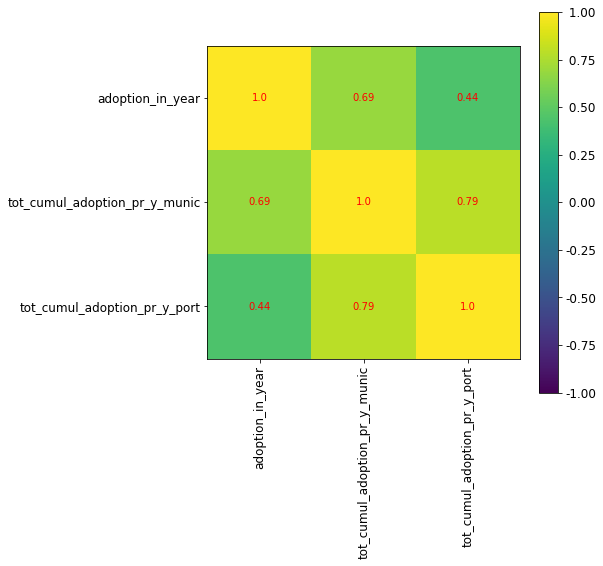

In [68]:
plot_correlation_heatmap(corr_matrix.loc[label + adoption_features, label + adoption_features], size=(7, 7))

In [69]:
sp_r_both.loc[adoption_features].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
tot_cumul_adoption_pr_y_munic,0.260,0.685
tot_cumul_adoption_pr_y_port,-0.011,0.441


In [70]:
class TransformAdoptionFeatures(BaseEstimator, TransformerMixin):
    """
    Transformer to reduce and transform the number of classes for each topic in census data.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        feats_to_keep = ["tot_cumul_adoption_pr_y_munic", "tot_cumul_adoption_pr_y_port"]
        
        return X[feats_to_keep]

### Soil and climate features

In [71]:
env_features = soil_features + climate_features

In [72]:
prec_features = [feat for feat in climate_features if '_prec' in feat]

In [73]:
sp_r_both.loc[prec_features].sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r
days_no_prec_pr_y_munic,-0.112,0.128
cons_days_no_prec_average_munic,-0.112,0.059
days_no_prec_average_munic,-0.115,0.056
cons_days_no_prec_pr_y_munic,-0.031,0.001
av_prec_sum_average_munic,0.043,-0.086
av_prec_sum_pr_y_munic,0.102,-0.164


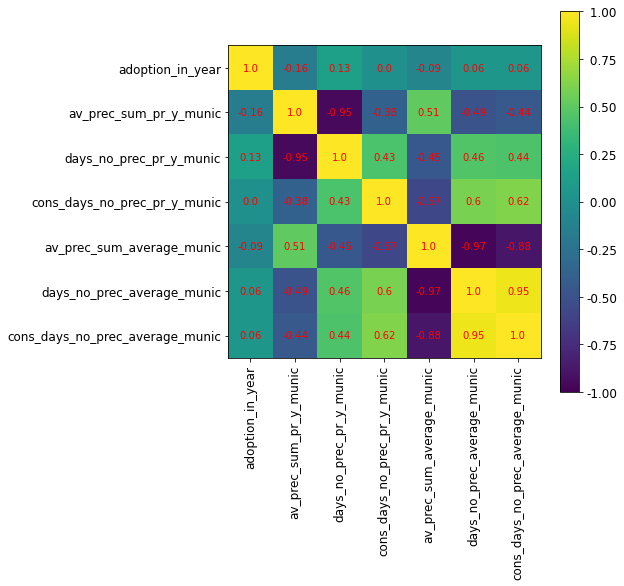

In [74]:
plot_correlation_heatmap(corr_matrix.loc[label + prec_features, label + prec_features], size=(7, 7))

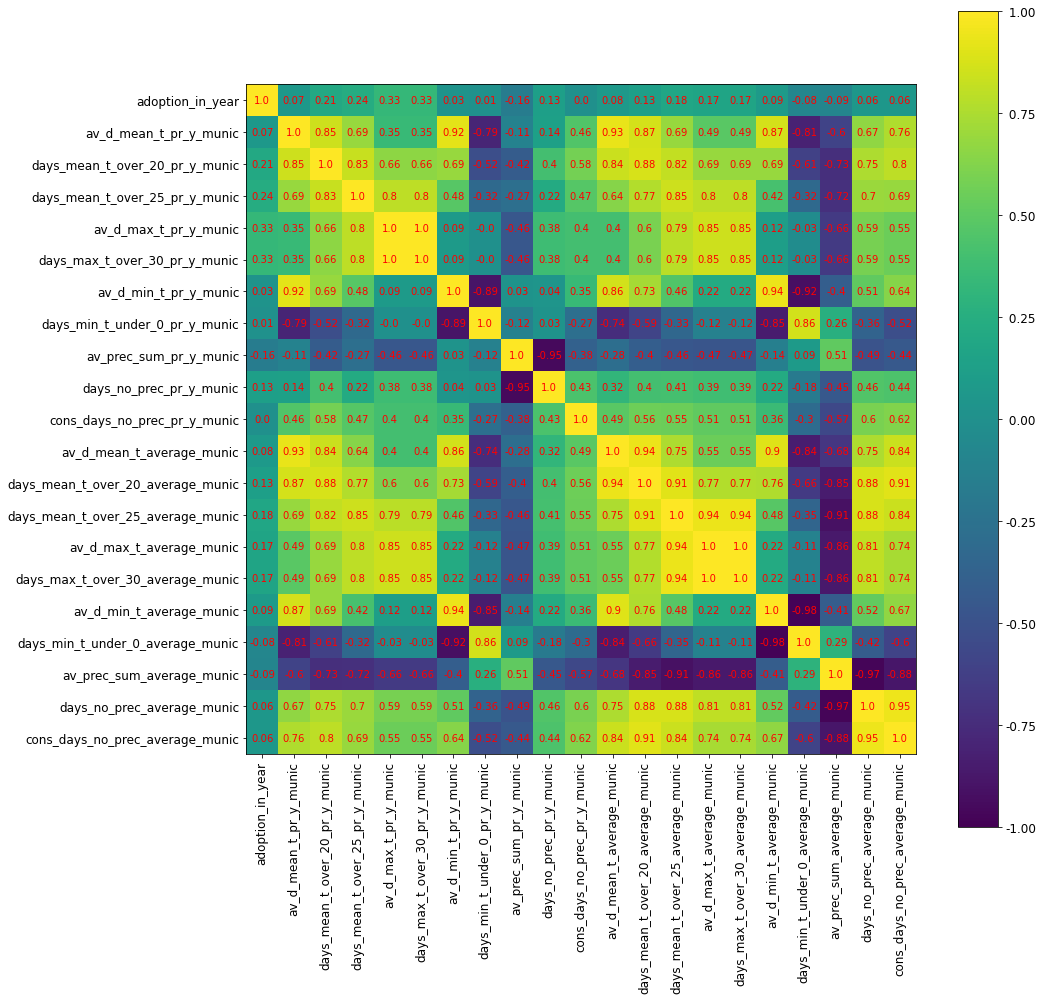

In [75]:
plot_correlation_heatmap(corr_matrix.loc[label + climate_features, label + climate_features], size=(15, 15))

In [76]:
feats_mean_t = [feat for feat in climate_features if 'av_d_mean_t' in feat]
feats_max_t = [feat for feat in climate_features if 'av_d_max_t' in feat]
feats_prec = [feat for feat in climate_features if 'cons_days_no_prec' in feat or 'av_prec_sum' in feat]
climate_features_kept = feats_mean_t + feats_max_t + feats_prec

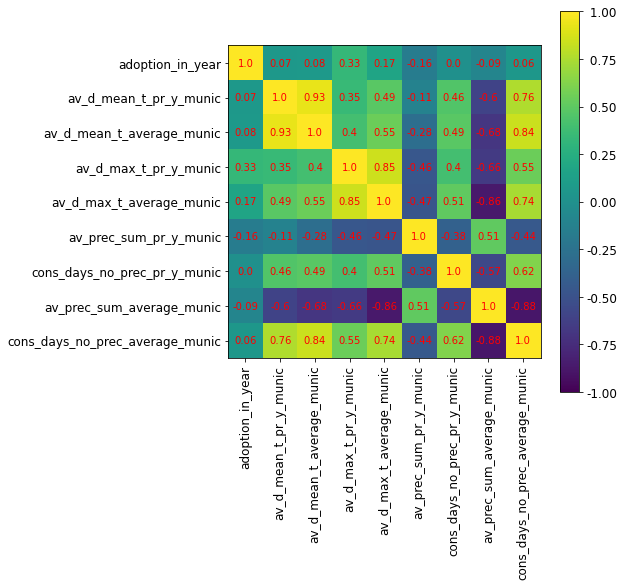

In [77]:
plot_correlation_heatmap(corr_matrix.loc[label + climate_features_kept, label + climate_features_kept], size=(7, 7))

In [78]:
sp_r_both.loc[climate_features_kept].sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r
av_d_max_t_pr_y_munic,0.133,0.328
av_d_max_t_average_munic,0.130,0.168
av_d_mean_t_average_munic,0.009,0.082
av_d_mean_t_pr_y_munic,0.084,0.071
cons_days_no_prec_average_munic,-0.112,0.059
cons_days_no_prec_pr_y_munic,-0.031,0.001
av_prec_sum_average_munic,0.043,-0.086
av_prec_sum_pr_y_munic,0.102,-0.164


In [79]:
class TransformClimateFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        climate_features = X.columns
        
        # All previous years ones excluded since the averages are more correlated!
        
        # Min temp: excluded all since high correlation with av_d_mean_t and
        # low with the target variable
        # Max temp: can keep only one of the two since perfectly correlated,
        # so exluded both days_max_t_over_30
        # Mean temp: excluded days_mean_t_over_20/25 since only one of these
        # kept and av_d_mean_t less correlated with max_t 
        # Prec: exclude both av_prec_sum_pr_y (too correlated with max_t) and
        # days_no
        
        # Definition of the ones to keep.
        feats_mean_t = [feat for feat in climate_features
                        if 'av_d_mean_t_average' in feat]
        feats_max_t = [feat for feat in climate_features
                        if 'av_d_max_t_average' in feat]
        feats_prec = [feat for feat in climate_features
                      if 'cons_days_no_prec_average' in feat]
        
        feats_to_keep = feats_mean_t + feats_max_t + feats_prec
        
        return X[feats_to_keep]

In [80]:
vif.loc[soil_features]

,VIF
features,
CaCO3_mean_munic,8.835
CN_mean_munic,20.436
N_mean_munic,3.727
P_mean_munic,5.922
pH_mean_munic,25.252


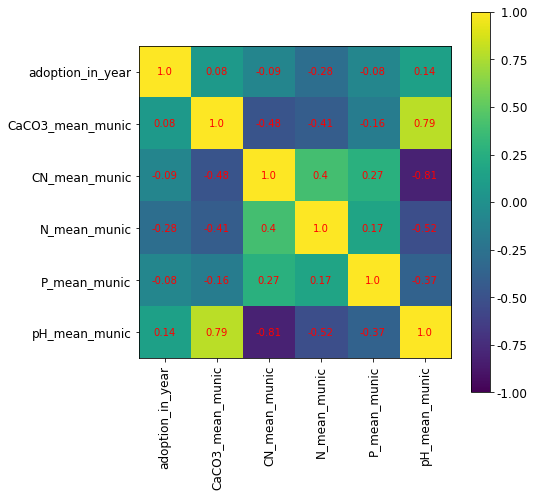

In [81]:
plot_correlation_heatmap(corr_matrix.loc[label + soil_features, label + soil_features], size=(7, 7))

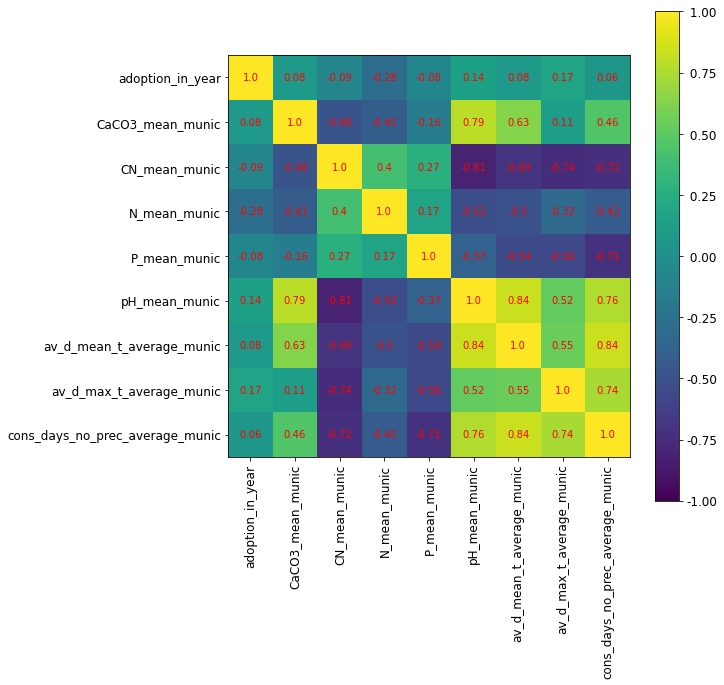

In [82]:
climate_features_kept_2 = ['av_d_mean_t_average_munic', 'av_d_max_t_average_munic', 'cons_days_no_prec_average_munic']
feats = label + soil_features + climate_features_kept_2
plot_correlation_heatmap(corr_matrix.loc[feats, feats], size=(9, 9))

In [83]:
spearman_results_both.loc[soil_features]

,spearman r only PCF,spearman r
CaCO3_mean_munic,0.175,0.084
CN_mean_munic,-0.108,-0.091
N_mean_munic,-0.229,-0.284
P_mean_munic,0.210,-0.083
pH_mean_munic,0.336,0.137


In [84]:
class TransformSoilFeatures(BaseEstimator, TransformerMixin):
    """
    Transformer to reduce and transform the number of classes for each topic in census data.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        soil_features = X.columns

        # 'pH_mean_munic' excluded since high correlation with NC and CaCO3 (also with av_d_mean_t_average_munic)
        
        # Definition of the ones to keep. 
        feats_to_keep = [feat for feat in soil_features if feat != 'pH_mean_munic']

        return X[feats_to_keep]

### Economic features

In [85]:
class TransformEconomicFeatures(BaseEstimator, TransformerMixin):
    """
    Transformer to reduce and transform the number of classes for each topic in census data.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        # Nothing to do, it's just sbp_payments and we pass it
        return X

### Create of a dataset with these transformations

In [130]:
# Get features names
feat_lists = [census_features, adoption_features, climate_features, soil_features, economic_features]
transformers = [TransformCensusFeatures(), TransformAdoptionFeatures(),
                TransformClimateFeatures(), TransformSoilFeatures(),
               TransformEconomicFeatures()]

features_red = []
for f, t in zip(feat_lists, transformers):
    features = t.transform(dataset[f]).columns.to_list()
    features_red = features_red + features

In [131]:
len(features_red)

19

In [132]:
dataset.shape

(2466, 45)

In [133]:
from sklearn.compose import ColumnTransformer

full_dataset_transformation = ColumnTransformer([
    ('census', TransformCensusFeatures(), census_features),
    ('adoption', TransformAdoptionFeatures(), adoption_features),
    ('climate', TransformClimateFeatures(), climate_features),
    ('soil', TransformSoilFeatures(), soil_features),
    ('economic', TransformEconomicFeatures(), economic_features)
],
    remainder='drop')

In [134]:
dataset_attr_red = full_dataset_transformation.fit_transform(dataset)
dataset_attr_red = pd.DataFrame(dataset_attr_red, columns=features_red)
dataset_attr_red.insert(0, 'adoption_in_year', dataset[label].values)

### Reassess VIF

In [135]:
vif_attr_red = calculate_vif(dataset_attr_red)

In [136]:
vif_attr_red.sort_values('VIF', ascending=False)

,VIF
features,
Intercept,2041.107
CN_mean_munic,10.260
cons_days_no_prec_average_munic,8.798
av_d_max_t_average_munic,6.740
work_unit_100ha,6.223
av_d_mean_t_average_munic,4.880
inc_mainly_ext,4.596
educ_second_super,4.553
tot_cumul_adoption_pr_y_port,3.767


# Outliers

In [93]:
df = dataset_attr_red.copy()

In [94]:
normalized_df=(df-df.min())/(df.max()-df.min())

<AxesSubplot:>

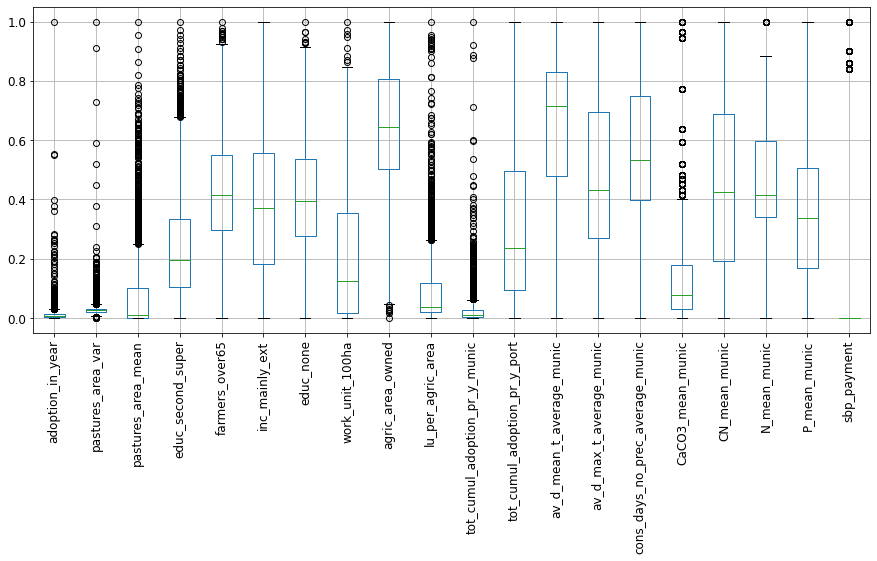

In [95]:
#mpl.rc('xtick', rotation=45, ha="right")
normalized_df.boxplot(figsize=(15, 6), rot=90)

## tot_cumul_adoption_pr_y_munic

<AxesSubplot:xlabel='tot_cumul_adoption_pr_y_munic', ylabel='adoption_in_year'>

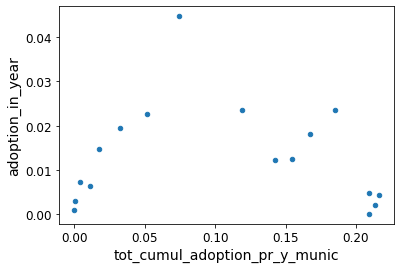

In [97]:
dataset_original.loc['Odemira'].plot(kind='scatter', x='tot_cumul_adoption_pr_y_munic', y='adoption_in_year')

### Remove outliers of adoption_in_year

{'whiskers': [<matplotlib.lines.Line2D at 0x2b8c5989460>,
 'caps': [<matplotlib.lines.Line2D at 0x2b8c5989fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b8c5989340>],
 'medians': [<matplotlib.lines.Line2D at 0x2b8c596aeb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2b8c596a9d0>],
 'means': []}

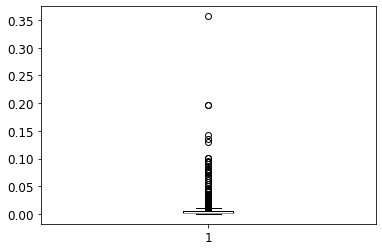

In [99]:
plt.boxplot(dataset['adoption_in_year'])

In [100]:
dataset_original.loc[dataset_original['adoption_in_year'] > 0.12]

adoption_in_year  tot_cumul_adoption_pr_y_munic  \
Municipality Year                                                    
Vagos        2007             0.357                          0.419   
             2008             0.129                          0.776   
Tomar        2005             0.142                          0.623   
Alcochete    2010             0.196                          0.195   
             2011             0.135                          0.391   
             2012             0.197                          0.526   

                   tot_cumul_adoption_pr_y_port  pastures_area_var  \
Municipality Year                                                    
Vagos        2007                         0.039              7.850   
             2008                         0.045              5.567   
Tomar        2005                         0.030              1.192   
Alcochete    2010                         0.056              1.000   
             2011                         0.065              1.007   
             2012                         0.070              1.013   

                   pastures_area_munic  pastures_area_mean  agric_area_mean  \
Municipality Year                                                             
Vagos        2007                0.034               0.068            2.120   
             2008                0.025               0.052            2.180   
Tomar        2005                0.164               0.544            3.400   
Alcochete    2010                0.524              11.632           22.200   
             2011                0.532              11.911           23.170   
             2012                0.540              12.200           24.140   

                   agric_area_owned  tract_100ha  lu_cattle  ...  \
Municipality Year                                            ...   
Vagos        2007             0.709       27.340      0.639  ...   
             2008             0.702       28.260      0.639  ...   
Tomar        2005             0.790       14.800      0.064  ...   
Alcochete    2010             0.768        4.300      0.332  ...   
             2011             0.748        4.390      0.319  ...   
             2012             0.728        4.480      0.308  ...   

                   days_min_t_under_0_average_munic  \
Municipality Year                                     
Vagos        2007                             2.181   
             2008                             2.181   
Tomar        2005                             0.771   
Alcochete    2010                             0.083   
             2011                             0.083   
             2012                             0.083   

                   av_prec_sum_average_munic  days_no_prec_average_munic  \
Municipality Year                                                          
Vagos        2007                    984.692                     269.875   
             2008                    984.692                     269.875   
Tomar        2005                    755.269                     284.958   
Alcochete    2010                    736.121                     282.125   
             2011                    736.121                     282.125   
             2012                    736.121                     282.125   

                   cons_days_no_prec_average_munic  CaCO3_mean_munic  \
Municipality Year                                                      
Vagos        2007                           53.111             4.442   
             2008                           53.111             4.442   
Tomar        2005                           65.448            23.416   
Alcochete    2010                           57.646            52.474   
             2011                           57.646            52.474   
             2012                           57.646            52.474   

                   CN_mean_munic  N_mean_munic  P_mean_munic  pH_mean_munic  \
Municipality 

In [101]:
dataset_red = dataset_original.drop(
    dataset_original.loc[dataset_original['adoption_in_year'] > 0.12].index
)
print(len(dataset), len(dataset_red))

2466 2460


### Reassessment of outlies in adoption features after first removal

In [104]:
df = dataset_red[['adoption_in_year', 'tot_cumul_adoption_pr_y_munic', 'tot_cumul_adoption_pr_y_port']]
norm_df_red=(df-df.min())/(df.max()-df.min())

<AxesSubplot:>

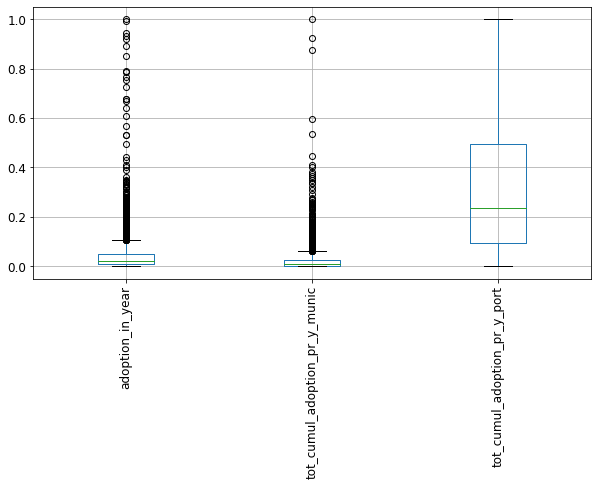

In [105]:
#mpl.rc('xtick', rotation=45, ha="right")
norm_df_red.boxplot(figsize=(10, 5), rot=90)

### Remove outliers of tot_cumul_adoption_pr_y_munic

{'whiskers': [<matplotlib.lines.Line2D at 0x2b8bed59880>,
 'caps': [<matplotlib.lines.Line2D at 0x2b8c20f5a00>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b8c1b6c070>],
 'medians': [<matplotlib.lines.Line2D at 0x2b8c20f5820>],
 'fliers': [<matplotlib.lines.Line2D at 0x2b8c1b391f0>],
 'means': []}

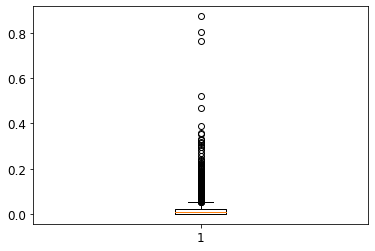

In [106]:
plt.boxplot(dataset_red['tot_cumul_adoption_pr_y_munic'])

In [107]:
dataset_red.loc[dataset_red['tot_cumul_adoption_pr_y_munic'] > 0.4]

adoption_in_year  tot_cumul_adoption_pr_y_munic  \
Municipality Year                                                    
Tomar        2003             0.054                          0.468   
             2004             0.101                          0.522   
             2006             0.041                          0.765   
             2007             0.068                          0.806   
             2008             0.021                          0.874   

                   tot_cumul_adoption_pr_y_port  pastures_area_var  \
Municipality Year                                                    
Tomar        2003                         0.017              1.269   
             2004                         0.023              1.231   
             2006                         0.035              1.154   
             2007                         0.039              1.115   
             2008                         0.045              1.077   

                   pastures_area_munic  pastures_area_mean  agric_area_mean  \
Municipality Year                                                             
Tomar        2003                0.169               0.549            3.320   
             2004                0.166               0.547            3.360   
             2006                0.161               0.541            3.440   
             2007                0.158               0.538            3.480   
             2008                0.155               0.535            3.520   

                   agric_area_owned  tract_100ha  lu_cattle  ...  \
Municipality Year                                            ...   
Tomar        2003             0.777       13.840      0.068  ...   
             2004             0.783       14.320      0.066  ...   
             2006             0.796       15.280      0.062  ...   
             2007             0.803       15.760      0.060  ...   
             2008             0.810       16.240      0.058  ...   

                   days_min_t_under_0_average_munic  \
Municipality Year                                     
Tomar        2003                             0.771   
             2004                             0.771   
             2006                             0.771   
             2007                             0.771   
             2008                             0.771   

                   av_prec_sum_average_munic  days_no_prec_average_munic  \
Municipality Year                                                          
Tomar        2003                    755.269                     284.958   
             2004                    755.269                     284.958   
             2006                    755.269                     284.958   
             2007                    755.269                     284.958   
             2008                    755.269                     284.958   

                   cons_days_no_prec_average_munic  CaCO3_mean_munic  \
Municipality Year                                                      
Tomar        2003                           65.448            23.416   
             2004                           65.448            23.416   
             2006                           65.448            23.416   
             2007                           65.448            23.416   
             2008                           65.448            23.416   

                   CN_mean_munic  N_mean_munic  P_mean_munic  pH_mean_munic  \
Municipality Year                                                             
Tomar        2003         15.231         1.365         8.639          5.845   
             2004         15.231         1.365         8.639          5.845   
             2006         15.231         1.365         8.639          5.845   
             2007         15.231         1.365         8.639          5.845   
             2008         15.231         1.365         8.639          5.845   

                   sbp_payme

In [108]:
dataset_red_2 = dataset_red.drop(
    dataset_red.loc[dataset_red['tot_cumul_adoption_pr_y_munic'] > 0.4].index
)
print(len(dataset_red), len(dataset_red_2))

2460 2455


### Reassessment of outlies in adoption features after second removal

In [110]:
df = dataset_red_2[['adoption_in_year', 'tot_cumul_adoption_pr_y_munic',
                   'tot_cumul_adoption_pr_y_port']]
norm_df_red_2=(df-df.min())/(df.max()-df.min())

<AxesSubplot:>

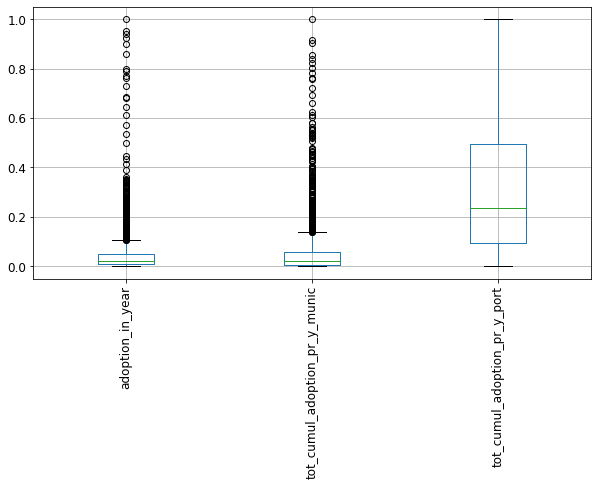

In [111]:
#mpl.rc('xtick', rotation=45, ha="right")
norm_df_red_2.boxplot(figsize=(10, 5), rot=90)

## Metrics for final set of features

In [137]:
d = pd.DataFrame(index=features_red)

In [138]:
d['VIF'] = vif_attr_red

In [139]:
dataset_attr_red_PCF = pd.DataFrame(dataset_attr_red.values, index=dataset_original.index,
                                        columns=dataset_attr_red.columns).loc[(slice(None), [2009, 2010, 2011, 2012]), :]

In [140]:
d2 = get_spearman_both(features_red, dataset_attr_red, dataset_attr_red_PCF)

In [141]:
d3 = pd.concat([d2, d], axis=1)

In [142]:
d3

,spearman r only PCF,spearman r,VIF
pastures_area_var,-0.039,0.353,1.108
pastures_area_mean,-0.026,0.162,2.869
educ_second_super,0.356,0.246,4.553
farmers_over65,-0.183,0.162,3.139
inc_mainly_ext,-0.275,-0.050,4.596
educ_none,-0.270,-0.424,3.100
work_unit_100ha,0.057,-0.153,6.223
agric_area_owned,0.001,-0.121,1.854
lu_per_agric_area,-0.005,-0.014,1.885
tot_cumul_adoption_pr_y_munic,0.260,0.685,1.304


In [143]:
corr_matrix_final = dataset_attr_red.corr(method='spearman').round(decimals=2)